# Import the supported Lib

In [1]:
import os
import torchvision
import numpy as np
from glob import glob
import torch
torch.cuda.current_device()
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets,transforms
#from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import shutil
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
from models import *
%matplotlib inline

# load the CIFAR10 dataset

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [3]:
#transformation = transforms.Compose([transforms.ToTensor()
#                                       ,transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#                                     ])

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), 
                                          transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    
    
train_dataset = datasets.SVHN('SVHN/',split='train',transform=train_transform,download=True)
test_dataset = datasets.SVHN('SVHN/',split='test',transform=test_transform,download=True)

train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100,shuffle=False)

Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [4]:
dataset_sizes = {'train':len(train_data_loader.dataset),'valid':len(valid_data_loader.dataset)}

In [5]:
dataloaders = {'train':train_data_loader,'valid':valid_data_loader}

# Import VGG('VGG19') Modle-desceding learning rate from 0.01

In [6]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

model_ft = VGG('VGG19')

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [7]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
#optimizer = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [9]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [10]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model_ft,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model_ft,valid_data_loader,phase='validation')
    scheduler.step()
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\ProgramData\Miniconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   2.3 and training accuracy is 13787/73257     18.82
validation loss is   2.1 and validation accuracy is 6304/26032     24.22
training loss is   1.6 and training accuracy is 30127/73257     41.13
validation loss is  0.91 and validation accuracy is 18069/26032     69.41
training loss is  0.56 and training accuracy is 60122/73257     82.07
validation loss is   0.4 and validation accuracy is 22801/26032     87.59
training loss is  0.38 and training accuracy is 64682/73257     88.29
validation loss is  0.43 and validation accuracy is 22707/26032     87.23
training loss is  0.32 and training accuracy is 66247/73257     90.43
validation loss is  0.31 and validation accuracy is 23641/26032     90.82
training loss is  0.29 and training accuracy is 66997/73257     91.45
validation loss is  0.28 and validation accuracy is 23832/26032     91.55
training loss is  0.27 and training accuracy is 67565/73257     92.23
validation loss is  0.28 and validation accuracy is 23923/26032    

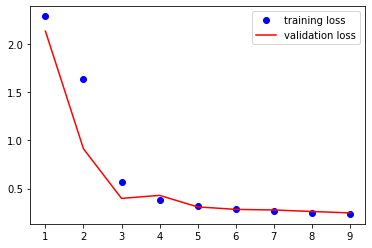

In [11]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

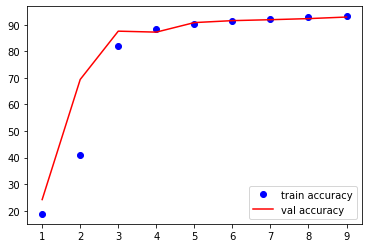

In [12]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

# Import VGG('VGG19') Modle-desceding learning rate from 0.001

In [13]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

model_ft = VGG('VGG19')

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [14]:
#optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer = optim.SGD(model_ft.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [15]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [16]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model_ft,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model_ft,valid_data_loader,phase='validation')
    scheduler.step()
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.4 and training accuracy is 37152/73257     50.71
validation loss is  0.65 and validation accuracy is 20470/26032     78.63
training loss is  0.53 and training accuracy is 60691/73257     82.85
validation loss is  0.43 and validation accuracy is 22453/26032     86.25
training loss is  0.39 and training accuracy is 64279/73257     87.74
validation loss is  0.35 and validation accuracy is 23209/26032     89.16
training loss is  0.33 and training accuracy is 65770/73257     89.78
validation loss is  0.29 and validation accuracy is 23759/26032     91.27
training loss is  0.29 and training accuracy is 66658/73257     90.99
validation loss is  0.27 and validation accuracy is 23909/26032     91.84
training loss is  0.27 and training accuracy is 67224/73257     91.76
validation loss is  0.28 and validation accuracy is 23804/26032     91.44
training loss is  0.25 and training accuracy is 67790/73257     92.54
validation loss is  0.24 and validation accuracy is 24140/26032   

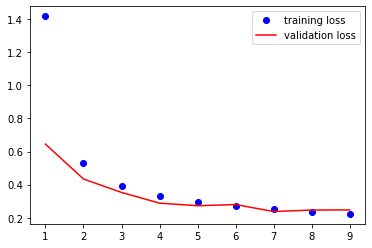

In [17]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

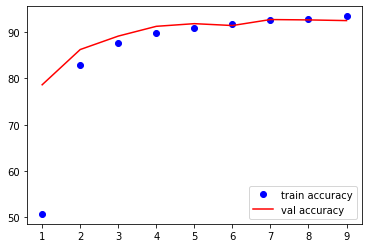

In [18]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

# Import VGG('VGG19') Modle- learning rate  0.01

In [19]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

model_ft = VGG('VGG19')

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [20]:
#optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [21]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [22]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model_ft,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model_ft,valid_data_loader,phase='validation')
    #scheduler.step()
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   2.3 and training accuracy is 13622/73257     18.59
validation loss is   2.2 and validation accuracy is 5099/26032     19.59
training loss is   2.3 and training accuracy is 13749/73257     18.77
validation loss is   2.3 and validation accuracy is 4977/26032     19.12
training loss is   1.9 and training accuracy is 23284/73257     31.78
validation loss is   1.2 and validation accuracy is 15510/26032     59.58
training loss is  0.64 and training accuracy is 57935/73257     79.08
validation loss is  0.53 and validation accuracy is 21558/26032     82.81
training loss is  0.39 and training accuracy is 64538/73257      88.1
validation loss is  0.34 and validation accuracy is 23363/26032     89.75
training loss is  0.33 and training accuracy is 66000/73257     90.09
validation loss is  0.26 and validation accuracy is 24044/26032     92.36
training loss is  0.29 and training accuracy is 67037/73257     91.51
validation loss is  0.24 and validation accuracy is 24235/26032     

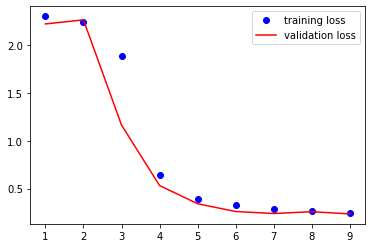

In [23]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

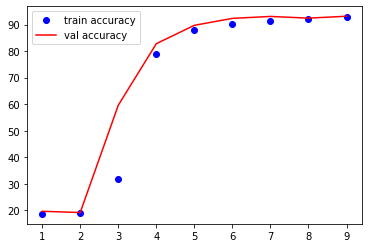

In [24]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

# Import VGG('VGG19') Modle- learning rate  0.001

In [25]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

model_ft = VGG('VGG19')

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [26]:
#optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer = optim.SGD(model_ft.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [27]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [28]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,model_ft,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model_ft,valid_data_loader,phase='validation')
    #scheduler.step()
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.6 and training accuracy is 32858/73257     44.85
validation loss is  0.82 and validation accuracy is 19131/26032     73.49
training loss is  0.58 and training accuracy is 59486/73257      81.2
validation loss is  0.51 and validation accuracy is 21687/26032     83.31
training loss is   0.4 and training accuracy is 64075/73257     87.47
validation loss is  0.38 and validation accuracy is 22989/26032     88.31
training loss is  0.34 and training accuracy is 65581/73257     89.52
validation loss is  0.37 and validation accuracy is 23057/26032     88.57
training loss is   0.3 and training accuracy is 66496/73257     90.77
validation loss is  0.28 and validation accuracy is 23869/26032     91.69
training loss is  0.27 and training accuracy is 67122/73257     91.63
validation loss is  0.26 and validation accuracy is 24031/26032     92.31
training loss is  0.25 and training accuracy is 67648/73257     92.34
validation loss is  0.26 and validation accuracy is 24010/26032   

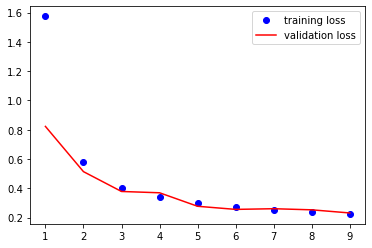

In [29]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

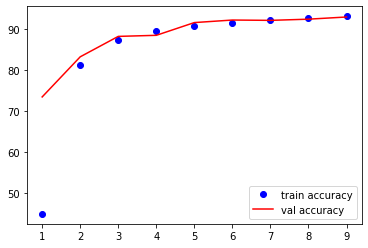

In [30]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()